In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rewards, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    #glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    ###################################################
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dlossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    #dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    ######################################################
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #if len(gQs_equal) > 0:
    if gQs_equal.shape[0] > 0:
        rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                        labels=rates_equal)) # 0-1
        targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
        dlossQ += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                         labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
        #dlossQ += tf.reduce_mean(tf.square(gQs_equal - targetQs_equal)) # DQN
    ########################################################
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    #if len(gQs_notequal) > 0:
    if gQs_notequal.shape[0] > 0:
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                        labels=tf.zeros_like(gQs_notequal))) # 0-1
        rewards_notequal = tf.boolean_mask(mask=mask_notequal, tensor=rewards)
        dlossQ += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                         labels=tf.nn.sigmoid(rewards_notequal))) # 0-1
        #dlossQ += tf.reduce_mean(tf.square(gQs_notequal - rewards_notequal)) # DQN
    return actions_logits, gQs, gloss, glossQ, dloss, dlossQ, gQs_notequal, gQs_equal

In [7]:
def model_opt(g_loss, g_lossQ, d_loss, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)
    return g_opt, g_optQ, d_opt, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.g_lossQ, self.d_loss, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rewards=self.rewards, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.g_optQ, self.d_opt, self.d_optQ = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                                                     g_lossQ=self.g_lossQ, d_lossQ=self.d_lossQ,
                                                                     g_learning_rate=g_learning_rate, 
                                                                     d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.rewards: rewards,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.rewards: rewards,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.rewards: rewards,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.rewards: rewards,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            # #if len(gQs_nonequal) != len(nextQs):
            # #if dloss is np.nan:            
            # if len(gQs_notequal) < 2:            
            # print(gQs_notequal.shape, gQs_notequal.dtype)
            # print(gQs_equal.shape, gQs_equal.dtype)
            # print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.6472 glossQ:0.7223 dloss:0.7212 dlossQ:0.6795 exploreP:0.9983
Episode:1 meanR:22.0000 R:27.0000 rate:0.0540 gloss:0.6421 glossQ:0.7247 dloss:0.7168 dlossQ:0.6810 exploreP:0.9957
Episode:2 meanR:29.0000 R:43.0000 rate:0.0860 gloss:0.6516 glossQ:0.7196 dloss:0.7284 dlossQ:0.6761 exploreP:0.9914
Episode:3 meanR:33.5000 R:47.0000 rate:0.0940 gloss:0.6489 glossQ:0.7208 dloss:0.7273 dlossQ:0.6768 exploreP:0.9868
Episode:4 meanR:29.6000 R:14.0000 rate:0.0280 gloss:0.6282 glossQ:0.7315 dloss:0.7034 dlossQ:0.6879 exploreP:0.9855
Episode:5 meanR:26.8333 R:13.0000 rate:0.0260 gloss:0.6483 glossQ:0.7216 dloss:0.7240 dlossQ:0.6787 exploreP:0.9842
Episode:6 meanR:29.5714 R:46.0000 rate:0.0920 gloss:0.6476 glossQ:0.7218 dloss:0.7248 dlossQ:0.6782 exploreP:0.9797
Episode:7 meanR:32.7500 R:55.0000 rate:0.1100 gloss:0.6474 glossQ:0.7226 dloss:0.7245 dlossQ:0.6781 exploreP:0.9744
Episode:8 meanR:30.4444 R:12.0000 rate:0.0240 gloss:0.6501 glossQ:0.7211

Episode:71 meanR:22.5556 R:21.0000 rate:0.0420 gloss:0.6393 glossQ:0.7271 dloss:0.7148 dlossQ:0.6831 exploreP:0.8516
Episode:72 meanR:22.6438 R:29.0000 rate:0.0580 gloss:0.6365 glossQ:0.7289 dloss:0.7094 dlossQ:0.6852 exploreP:0.8492
Episode:73 meanR:22.5000 R:12.0000 rate:0.0240 gloss:0.6436 glossQ:0.7245 dloss:0.7210 dlossQ:0.6799 exploreP:0.8482
Episode:74 meanR:22.4000 R:15.0000 rate:0.0300 gloss:0.6400 glossQ:0.7270 dloss:0.7154 dlossQ:0.6824 exploreP:0.8469
Episode:75 meanR:22.3289 R:17.0000 rate:0.0340 gloss:0.6462 glossQ:0.7220 dloss:0.7214 dlossQ:0.6796 exploreP:0.8455
Episode:76 meanR:22.3506 R:24.0000 rate:0.0480 gloss:0.6344 glossQ:0.7293 dloss:0.7089 dlossQ:0.6850 exploreP:0.8435
Episode:77 meanR:22.5128 R:35.0000 rate:0.0700 gloss:0.6448 glossQ:0.7245 dloss:0.7188 dlossQ:0.6807 exploreP:0.8406
Episode:78 meanR:22.6582 R:34.0000 rate:0.0680 gloss:0.6468 glossQ:0.7230 dloss:0.7219 dlossQ:0.6796 exploreP:0.8377
Episode:79 meanR:22.5250 R:12.0000 rate:0.0240 gloss:0.6485 glos

Episode:141 meanR:19.5600 R:15.0000 rate:0.0300 gloss:0.6438 glossQ:0.7247 dloss:0.7225 dlossQ:0.6790 exploreP:0.7469
Episode:142 meanR:19.2200 R:11.0000 rate:0.0220 gloss:0.6431 glossQ:0.7240 dloss:0.7207 dlossQ:0.6805 exploreP:0.7461
Episode:143 meanR:19.4100 R:32.0000 rate:0.0640 gloss:0.6418 glossQ:0.7255 dloss:0.7207 dlossQ:0.6804 exploreP:0.7438
Episode:144 meanR:19.3600 R:15.0000 rate:0.0300 gloss:0.6364 glossQ:0.7267 dloss:0.7150 dlossQ:0.6820 exploreP:0.7427
Episode:145 meanR:18.8900 R:15.0000 rate:0.0300 gloss:0.6442 glossQ:0.7250 dloss:0.7171 dlossQ:0.6812 exploreP:0.7416
Episode:146 meanR:18.8300 R:18.0000 rate:0.0360 gloss:0.6353 glossQ:0.7283 dloss:0.7105 dlossQ:0.6841 exploreP:0.7403
Episode:147 meanR:18.7300 R:14.0000 rate:0.0280 gloss:0.6426 glossQ:0.7249 dloss:0.7169 dlossQ:0.6807 exploreP:0.7392
Episode:148 meanR:18.8700 R:27.0000 rate:0.0540 gloss:0.6403 glossQ:0.7268 dloss:0.7167 dlossQ:0.6816 exploreP:0.7373
Episode:149 meanR:18.9000 R:16.0000 rate:0.0320 gloss:0.

Episode:211 meanR:17.8200 R:39.0000 rate:0.0780 gloss:0.6365 glossQ:0.7278 dloss:0.7139 dlossQ:0.6832 exploreP:0.6656
Episode:212 meanR:17.8000 R:14.0000 rate:0.0280 gloss:0.6312 glossQ:0.7314 dloss:0.7068 dlossQ:0.6858 exploreP:0.6647
Episode:213 meanR:17.7100 R:18.0000 rate:0.0360 gloss:0.6372 glossQ:0.7285 dloss:0.7136 dlossQ:0.6836 exploreP:0.6635
Episode:214 meanR:17.6500 R:11.0000 rate:0.0220 gloss:0.6354 glossQ:0.7284 dloss:0.7135 dlossQ:0.6831 exploreP:0.6628
Episode:215 meanR:17.7000 R:17.0000 rate:0.0340 gloss:0.6399 glossQ:0.7265 dloss:0.7151 dlossQ:0.6823 exploreP:0.6616
Episode:216 meanR:17.5500 R:12.0000 rate:0.0240 gloss:0.6137 glossQ:0.7390 dloss:0.6858 dlossQ:0.6950 exploreP:0.6609
Episode:217 meanR:17.7400 R:28.0000 rate:0.0560 gloss:0.6358 glossQ:0.7291 dloss:0.7099 dlossQ:0.6855 exploreP:0.6590
Episode:218 meanR:18.1900 R:56.0000 rate:0.1120 gloss:0.6394 glossQ:0.7262 dloss:0.7170 dlossQ:0.6812 exploreP:0.6554
Episode:219 meanR:18.1200 R:31.0000 rate:0.0620 gloss:0.

Episode:281 meanR:17.0200 R:14.0000 rate:0.0280 gloss:0.6297 glossQ:0.7322 dloss:0.7095 dlossQ:0.6859 exploreP:0.5930
Episode:282 meanR:17.0300 R:19.0000 rate:0.0380 gloss:0.6376 glossQ:0.7281 dloss:0.7148 dlossQ:0.6833 exploreP:0.5919
Episode:283 meanR:16.9800 R:13.0000 rate:0.0260 gloss:0.6471 glossQ:0.7221 dloss:0.7312 dlossQ:0.6756 exploreP:0.5911
Episode:284 meanR:16.9600 R:9.0000 rate:0.0180 gloss:0.6353 glossQ:0.7307 dloss:0.7098 dlossQ:0.6862 exploreP:0.5906
Episode:285 meanR:17.1000 R:34.0000 rate:0.0680 gloss:0.6417 glossQ:0.7263 dloss:0.7190 dlossQ:0.6810 exploreP:0.5887
Episode:286 meanR:17.0500 R:11.0000 rate:0.0220 gloss:0.6355 glossQ:0.7287 dloss:0.7153 dlossQ:0.6830 exploreP:0.5880
Episode:287 meanR:16.9800 R:13.0000 rate:0.0260 gloss:0.6407 glossQ:0.7283 dloss:0.7160 dlossQ:0.6824 exploreP:0.5873
Episode:288 meanR:16.9700 R:10.0000 rate:0.0200 gloss:0.6251 glossQ:0.7367 dloss:0.6934 dlossQ:0.6928 exploreP:0.5867
Episode:289 meanR:17.0100 R:18.0000 rate:0.0360 gloss:0.6

Episode:351 meanR:15.2500 R:10.0000 rate:0.0200 gloss:0.6382 glossQ:0.7268 dloss:0.7204 dlossQ:0.6805 exploreP:0.5344
Episode:352 meanR:15.2200 R:11.0000 rate:0.0220 gloss:0.6289 glossQ:0.7323 dloss:0.7058 dlossQ:0.6865 exploreP:0.5338
Episode:353 meanR:15.1600 R:14.0000 rate:0.0280 gloss:0.6343 glossQ:0.7288 dloss:0.7137 dlossQ:0.6832 exploreP:0.5331
Episode:354 meanR:15.0100 R:11.0000 rate:0.0220 gloss:0.6349 glossQ:0.7288 dloss:0.7146 dlossQ:0.6836 exploreP:0.5325
Episode:355 meanR:14.9500 R:9.0000 rate:0.0180 gloss:0.6292 glossQ:0.7345 dloss:0.7017 dlossQ:0.6883 exploreP:0.5321
Episode:356 meanR:14.8600 R:14.0000 rate:0.0280 gloss:0.6319 glossQ:0.7304 dloss:0.7097 dlossQ:0.6843 exploreP:0.5313
Episode:357 meanR:14.8600 R:12.0000 rate:0.0240 gloss:0.6425 glossQ:0.7250 dloss:0.7203 dlossQ:0.6812 exploreP:0.5307
Episode:358 meanR:14.9000 R:19.0000 rate:0.0380 gloss:0.6334 glossQ:0.7300 dloss:0.7111 dlossQ:0.6851 exploreP:0.5297
Episode:359 meanR:14.8900 R:11.0000 rate:0.0220 gloss:0.6

Episode:421 meanR:14.1000 R:18.0000 rate:0.0360 gloss:0.6238 glossQ:0.7337 dloss:0.7016 dlossQ:0.6879 exploreP:0.4864
Episode:422 meanR:14.0700 R:12.0000 rate:0.0240 gloss:0.6346 glossQ:0.7312 dloss:0.7067 dlossQ:0.6865 exploreP:0.4858
Episode:423 meanR:14.1000 R:15.0000 rate:0.0300 gloss:0.6322 glossQ:0.7312 dloss:0.7087 dlossQ:0.6858 exploreP:0.4851
Episode:424 meanR:14.1200 R:12.0000 rate:0.0240 gloss:0.6370 glossQ:0.7295 dloss:0.7139 dlossQ:0.6832 exploreP:0.4845
Episode:425 meanR:13.9900 R:13.0000 rate:0.0260 gloss:0.6368 glossQ:0.7291 dloss:0.7105 dlossQ:0.6847 exploreP:0.4839
Episode:426 meanR:14.1800 R:31.0000 rate:0.0620 gloss:0.6337 glossQ:0.7320 dloss:0.7084 dlossQ:0.6855 exploreP:0.4824
Episode:427 meanR:14.1800 R:11.0000 rate:0.0220 gloss:0.6204 glossQ:0.7380 dloss:0.6911 dlossQ:0.6933 exploreP:0.4819
Episode:428 meanR:13.9800 R:15.0000 rate:0.0300 gloss:0.6399 glossQ:0.7281 dloss:0.7175 dlossQ:0.6813 exploreP:0.4812
Episode:429 meanR:13.9200 R:12.0000 rate:0.0240 gloss:0.

Episode:491 meanR:12.7200 R:15.0000 rate:0.0300 gloss:0.6364 glossQ:0.7275 dloss:0.7178 dlossQ:0.6820 exploreP:0.4459
Episode:492 meanR:12.6500 R:10.0000 rate:0.0200 gloss:0.6316 glossQ:0.7309 dloss:0.7065 dlossQ:0.6861 exploreP:0.4455
Episode:493 meanR:12.6600 R:11.0000 rate:0.0220 gloss:0.6288 glossQ:0.7325 dloss:0.7057 dlossQ:0.6873 exploreP:0.4450
Episode:494 meanR:12.6000 R:12.0000 rate:0.0240 gloss:0.6422 glossQ:0.7257 dloss:0.7221 dlossQ:0.6802 exploreP:0.4445
Episode:495 meanR:12.5700 R:12.0000 rate:0.0240 gloss:0.6236 glossQ:0.7367 dloss:0.6945 dlossQ:0.6924 exploreP:0.4440
Episode:496 meanR:12.4400 R:9.0000 rate:0.0180 gloss:0.6324 glossQ:0.7309 dloss:0.7066 dlossQ:0.6863 exploreP:0.4436
Episode:497 meanR:12.4000 R:14.0000 rate:0.0280 gloss:0.6362 glossQ:0.7275 dloss:0.7171 dlossQ:0.6821 exploreP:0.4430
Episode:498 meanR:12.4200 R:12.0000 rate:0.0240 gloss:0.6232 glossQ:0.7354 dloss:0.6978 dlossQ:0.6908 exploreP:0.4425
Episode:499 meanR:12.3900 R:14.0000 rate:0.0280 gloss:0.6

Episode:561 meanR:12.2000 R:10.0000 rate:0.0200 gloss:0.6397 glossQ:0.7289 dloss:0.7166 dlossQ:0.6819 exploreP:0.4099
Episode:562 meanR:12.2100 R:13.0000 rate:0.0260 gloss:0.6089 glossQ:0.7389 dloss:0.6836 dlossQ:0.6939 exploreP:0.4094
Episode:563 meanR:12.1700 R:11.0000 rate:0.0220 gloss:0.6331 glossQ:0.7301 dloss:0.7168 dlossQ:0.6832 exploreP:0.4089
Episode:564 meanR:12.2700 R:20.0000 rate:0.0400 gloss:0.6210 glossQ:0.7369 dloss:0.6964 dlossQ:0.6912 exploreP:0.4081
Episode:565 meanR:12.2700 R:11.0000 rate:0.0220 gloss:0.6260 glossQ:0.7326 dloss:0.7066 dlossQ:0.6871 exploreP:0.4077
Episode:566 meanR:12.2500 R:12.0000 rate:0.0240 gloss:0.6318 glossQ:0.7314 dloss:0.7094 dlossQ:0.6854 exploreP:0.4072
Episode:567 meanR:12.2800 R:12.0000 rate:0.0240 gloss:0.6380 glossQ:0.7279 dloss:0.7220 dlossQ:0.6800 exploreP:0.4067
Episode:568 meanR:12.3300 R:15.0000 rate:0.0300 gloss:0.6404 glossQ:0.7279 dloss:0.7203 dlossQ:0.6819 exploreP:0.4062
Episode:569 meanR:12.3400 R:12.0000 rate:0.0240 gloss:0.

Episode:631 meanR:12.0900 R:14.0000 rate:0.0280 gloss:0.6344 glossQ:0.7280 dloss:0.7216 dlossQ:0.6805 exploreP:0.3765
Episode:632 meanR:12.0100 R:9.0000 rate:0.0180 gloss:0.6399 glossQ:0.7246 dloss:0.7307 dlossQ:0.6764 exploreP:0.3762
Episode:633 meanR:12.0300 R:11.0000 rate:0.0220 gloss:0.6363 glossQ:0.7305 dloss:0.7105 dlossQ:0.6853 exploreP:0.3758
Episode:634 meanR:12.0300 R:13.0000 rate:0.0260 gloss:0.6292 glossQ:0.7344 dloss:0.7039 dlossQ:0.6893 exploreP:0.3753
Episode:635 meanR:12.0300 R:10.0000 rate:0.0200 gloss:0.6430 glossQ:0.7254 dloss:0.7205 dlossQ:0.6801 exploreP:0.3750
Episode:636 meanR:12.0100 R:9.0000 rate:0.0180 gloss:0.6340 glossQ:0.7296 dloss:0.7126 dlossQ:0.6833 exploreP:0.3746
Episode:637 meanR:12.0500 R:13.0000 rate:0.0260 gloss:0.6261 glossQ:0.7328 dloss:0.7056 dlossQ:0.6861 exploreP:0.3742
Episode:638 meanR:12.0400 R:8.0000 rate:0.0160 gloss:0.6397 glossQ:0.7279 dloss:0.7187 dlossQ:0.6809 exploreP:0.3739
Episode:639 meanR:12.0400 R:12.0000 rate:0.0240 gloss:0.622

Episode:701 meanR:11.3700 R:13.0000 rate:0.0260 gloss:0.6408 glossQ:0.7269 dloss:0.7218 dlossQ:0.6807 exploreP:0.3490
Episode:702 meanR:11.2700 R:11.0000 rate:0.0220 gloss:0.6220 glossQ:0.7340 dloss:0.7007 dlossQ:0.6885 exploreP:0.3486
Episode:703 meanR:11.2400 R:12.0000 rate:0.0240 gloss:0.6352 glossQ:0.7308 dloss:0.7139 dlossQ:0.6843 exploreP:0.3482
Episode:704 meanR:11.3100 R:19.0000 rate:0.0380 gloss:0.6289 glossQ:0.7333 dloss:0.7087 dlossQ:0.6866 exploreP:0.3476
Episode:705 meanR:11.2700 R:11.0000 rate:0.0220 gloss:0.6262 glossQ:0.7333 dloss:0.7047 dlossQ:0.6880 exploreP:0.3472
Episode:706 meanR:11.3000 R:14.0000 rate:0.0280 gloss:0.6178 glossQ:0.7411 dloss:0.6899 dlossQ:0.6962 exploreP:0.3467
Episode:707 meanR:11.3100 R:11.0000 rate:0.0220 gloss:0.6431 glossQ:0.7246 dloss:0.7304 dlossQ:0.6771 exploreP:0.3464
Episode:708 meanR:11.3100 R:12.0000 rate:0.0240 gloss:0.6283 glossQ:0.7333 dloss:0.7071 dlossQ:0.6860 exploreP:0.3460
Episode:709 meanR:11.3000 R:9.0000 rate:0.0180 gloss:0.6

Episode:771 meanR:11.2600 R:13.0000 rate:0.0260 gloss:0.6293 glossQ:0.7324 dloss:0.7047 dlossQ:0.6877 exploreP:0.3232
Episode:772 meanR:11.3600 R:19.0000 rate:0.0380 gloss:0.6197 glossQ:0.7373 dloss:0.6942 dlossQ:0.6935 exploreP:0.3226
Episode:773 meanR:11.3900 R:12.0000 rate:0.0240 gloss:0.6294 glossQ:0.7327 dloss:0.7118 dlossQ:0.6858 exploreP:0.3222
Episode:774 meanR:11.3800 R:9.0000 rate:0.0180 gloss:0.6181 glossQ:0.7357 dloss:0.6975 dlossQ:0.6906 exploreP:0.3219
Episode:775 meanR:11.3400 R:8.0000 rate:0.0160 gloss:0.6171 glossQ:0.7396 dloss:0.6949 dlossQ:0.6927 exploreP:0.3217
Episode:776 meanR:11.3700 R:14.0000 rate:0.0280 gloss:0.6260 glossQ:0.7366 dloss:0.7000 dlossQ:0.6920 exploreP:0.3212
Episode:777 meanR:11.3800 R:11.0000 rate:0.0220 gloss:0.6277 glossQ:0.7322 dloss:0.7015 dlossQ:0.6884 exploreP:0.3209
Episode:778 meanR:11.3000 R:10.0000 rate:0.0200 gloss:0.6383 glossQ:0.7282 dloss:0.7144 dlossQ:0.6839 exploreP:0.3206
Episode:779 meanR:11.3100 R:11.0000 rate:0.0220 gloss:0.63

Episode:841 meanR:11.2900 R:18.0000 rate:0.0360 gloss:0.6351 glossQ:0.7314 dloss:0.7062 dlossQ:0.6884 exploreP:0.2991
Episode:842 meanR:11.3200 R:13.0000 rate:0.0260 gloss:0.6292 glossQ:0.7307 dloss:0.6948 dlossQ:0.6905 exploreP:0.2987
Episode:843 meanR:11.3300 R:15.0000 rate:0.0300 gloss:0.6324 glossQ:0.7310 dloss:0.7162 dlossQ:0.6853 exploreP:0.2983
Episode:844 meanR:11.3300 R:10.0000 rate:0.0200 gloss:0.6279 glossQ:0.7335 dloss:0.7093 dlossQ:0.6885 exploreP:0.2980
Episode:845 meanR:11.3000 R:8.0000 rate:0.0160 gloss:0.6231 glossQ:0.7350 dloss:0.6960 dlossQ:0.6918 exploreP:0.2978
Episode:846 meanR:11.1900 R:10.0000 rate:0.0200 gloss:0.6326 glossQ:0.7290 dloss:0.7166 dlossQ:0.6832 exploreP:0.2975
Episode:847 meanR:11.1700 R:9.0000 rate:0.0180 gloss:0.6211 glossQ:0.7374 dloss:0.6915 dlossQ:0.6959 exploreP:0.2972
Episode:848 meanR:11.1400 R:8.0000 rate:0.0160 gloss:0.6299 glossQ:0.7305 dloss:0.7165 dlossQ:0.6844 exploreP:0.2970
Episode:849 meanR:11.1400 R:11.0000 rate:0.0220 gloss:0.629

Episode:911 meanR:10.8800 R:19.0000 rate:0.0380 gloss:0.6204 glossQ:0.7339 dloss:0.6951 dlossQ:0.6927 exploreP:0.2778
Episode:912 meanR:10.8800 R:10.0000 rate:0.0200 gloss:0.6275 glossQ:0.7322 dloss:0.7027 dlossQ:0.6889 exploreP:0.2775
Episode:913 meanR:10.9000 R:14.0000 rate:0.0280 gloss:0.6223 glossQ:0.7351 dloss:0.7075 dlossQ:0.6899 exploreP:0.2771
Episode:914 meanR:10.9100 R:10.0000 rate:0.0200 gloss:0.6355 glossQ:0.7311 dloss:0.7112 dlossQ:0.6875 exploreP:0.2769
Episode:915 meanR:10.8400 R:10.0000 rate:0.0200 gloss:0.6265 glossQ:0.7341 dloss:0.6980 dlossQ:0.6918 exploreP:0.2766
Episode:916 meanR:10.8600 R:14.0000 rate:0.0280 gloss:0.6289 glossQ:0.7326 dloss:0.7092 dlossQ:0.6874 exploreP:0.2762
Episode:917 meanR:10.8700 R:12.0000 rate:0.0240 gloss:0.6276 glossQ:0.7331 dloss:0.7074 dlossQ:0.6879 exploreP:0.2759
Episode:918 meanR:10.8700 R:9.0000 rate:0.0180 gloss:0.6302 glossQ:0.7297 dloss:0.7158 dlossQ:0.6834 exploreP:0.2757
Episode:919 meanR:10.8600 R:9.0000 rate:0.0180 gloss:0.63

Episode:981 meanR:10.8500 R:12.0000 rate:0.0240 gloss:0.6284 glossQ:0.7332 dloss:0.7168 dlossQ:0.6849 exploreP:0.2582
Episode:982 meanR:10.8400 R:9.0000 rate:0.0180 gloss:0.6401 glossQ:0.7258 dloss:0.7323 dlossQ:0.6785 exploreP:0.2580
Episode:983 meanR:10.8500 R:10.0000 rate:0.0200 gloss:0.6406 glossQ:0.7276 dloss:0.7293 dlossQ:0.6790 exploreP:0.2577
Episode:984 meanR:10.8700 R:11.0000 rate:0.0220 gloss:0.6331 glossQ:0.7300 dloss:0.7196 dlossQ:0.6844 exploreP:0.2574
Episode:985 meanR:10.8800 R:10.0000 rate:0.0200 gloss:0.6264 glossQ:0.7347 dloss:0.7033 dlossQ:0.6904 exploreP:0.2572
Episode:986 meanR:10.8600 R:10.0000 rate:0.0200 gloss:0.6432 glossQ:0.7233 dloss:0.7447 dlossQ:0.6733 exploreP:0.2570
Episode:987 meanR:10.8700 R:11.0000 rate:0.0220 gloss:0.6207 glossQ:0.7333 dloss:0.7058 dlossQ:0.6887 exploreP:0.2567
Episode:988 meanR:10.8400 R:9.0000 rate:0.0180 gloss:0.6380 glossQ:0.7302 dloss:0.7153 dlossQ:0.6862 exploreP:0.2565
Episode:989 meanR:10.8300 R:9.0000 rate:0.0180 gloss:0.633

Episode:1051 meanR:11.0300 R:10.0000 rate:0.0200 gloss:0.6278 glossQ:0.7347 dloss:0.7007 dlossQ:0.6932 exploreP:0.2396
Episode:1052 meanR:11.0200 R:10.0000 rate:0.0200 gloss:0.6317 glossQ:0.7322 dloss:0.7088 dlossQ:0.6881 exploreP:0.2394
Episode:1053 meanR:11.0200 R:10.0000 rate:0.0200 gloss:0.6320 glossQ:0.7332 dloss:0.7070 dlossQ:0.6894 exploreP:0.2392
Episode:1054 meanR:11.0000 R:9.0000 rate:0.0180 gloss:0.6392 glossQ:0.7284 dloss:0.7151 dlossQ:0.6858 exploreP:0.2390
Episode:1055 meanR:10.9800 R:9.0000 rate:0.0180 gloss:0.6404 glossQ:0.7234 dloss:0.7432 dlossQ:0.6753 exploreP:0.2387
Episode:1056 meanR:10.9800 R:11.0000 rate:0.0220 gloss:0.6335 glossQ:0.7289 dloss:0.7262 dlossQ:0.6828 exploreP:0.2385
Episode:1057 meanR:10.9400 R:11.0000 rate:0.0220 gloss:0.6201 glossQ:0.7351 dloss:0.6946 dlossQ:0.6957 exploreP:0.2382
Episode:1058 meanR:10.9700 R:11.0000 rate:0.0220 gloss:0.6368 glossQ:0.7290 dloss:0.7141 dlossQ:0.6848 exploreP:0.2380
Episode:1059 meanR:11.0400 R:17.0000 rate:0.0340 g

Episode:1120 meanR:11.1100 R:9.0000 rate:0.0180 gloss:0.6134 glossQ:0.7430 dloss:0.6706 dlossQ:0.7087 exploreP:0.2229
Episode:1121 meanR:11.1200 R:10.0000 rate:0.0200 gloss:0.6473 glossQ:0.7228 dloss:0.7283 dlossQ:0.6781 exploreP:0.2226
Episode:1122 meanR:11.1500 R:12.0000 rate:0.0240 gloss:0.6417 glossQ:0.7276 dloss:0.7253 dlossQ:0.6812 exploreP:0.2224
Episode:1123 meanR:11.1800 R:13.0000 rate:0.0260 gloss:0.6336 glossQ:0.7288 dloss:0.7197 dlossQ:0.6840 exploreP:0.2221
Episode:1124 meanR:11.1800 R:10.0000 rate:0.0200 gloss:0.6269 glossQ:0.7370 dloss:0.7120 dlossQ:0.6884 exploreP:0.2219
Episode:1125 meanR:11.2000 R:13.0000 rate:0.0260 gloss:0.6368 glossQ:0.7282 dloss:0.7109 dlossQ:0.6876 exploreP:0.2216
Episode:1126 meanR:11.1500 R:10.0000 rate:0.0200 gloss:0.6292 glossQ:0.7306 dloss:0.7130 dlossQ:0.6887 exploreP:0.2214
Episode:1127 meanR:11.1700 R:11.0000 rate:0.0220 gloss:0.6362 glossQ:0.7289 dloss:0.7159 dlossQ:0.6854 exploreP:0.2212
Episode:1128 meanR:11.1600 R:9.0000 rate:0.0180 g

Episode:1190 meanR:10.7600 R:11.0000 rate:0.0220 gloss:0.6286 glossQ:0.7298 dloss:0.7119 dlossQ:0.6880 exploreP:0.2075
Episode:1191 meanR:10.7500 R:10.0000 rate:0.0200 gloss:0.6170 glossQ:0.7377 dloss:0.7061 dlossQ:0.6912 exploreP:0.2073
Episode:1192 meanR:10.7300 R:10.0000 rate:0.0200 gloss:0.6371 glossQ:0.7243 dloss:0.7321 dlossQ:0.6776 exploreP:0.2071
Episode:1193 meanR:10.7200 R:9.0000 rate:0.0180 gloss:0.6328 glossQ:0.7333 dloss:0.7004 dlossQ:0.6934 exploreP:0.2069
Episode:1194 meanR:10.7200 R:10.0000 rate:0.0200 gloss:0.6261 glossQ:0.7333 dloss:0.6931 dlossQ:0.6966 exploreP:0.2067
Episode:1195 meanR:10.7000 R:8.0000 rate:0.0160 gloss:0.6390 glossQ:0.7268 dloss:0.7258 dlossQ:0.6832 exploreP:0.2066
Episode:1196 meanR:10.7100 R:10.0000 rate:0.0200 gloss:0.6378 glossQ:0.7252 dloss:0.7270 dlossQ:0.6801 exploreP:0.2064
Episode:1197 meanR:10.7200 R:11.0000 rate:0.0220 gloss:0.6360 glossQ:0.7272 dloss:0.7252 dlossQ:0.6811 exploreP:0.2062
Episode:1198 meanR:10.7300 R:10.0000 rate:0.0200 g

Episode:1260 meanR:10.5400 R:16.0000 rate:0.0320 gloss:0.6383 glossQ:0.7253 dloss:0.7374 dlossQ:0.6774 exploreP:0.1935
Episode:1261 meanR:10.5800 R:14.0000 rate:0.0280 gloss:0.6279 glossQ:0.7321 dloss:0.7153 dlossQ:0.6876 exploreP:0.1932
Episode:1262 meanR:10.5900 R:9.0000 rate:0.0180 gloss:0.6391 glossQ:0.7276 dloss:0.7252 dlossQ:0.6824 exploreP:0.1930
Episode:1263 meanR:10.5900 R:9.0000 rate:0.0180 gloss:0.6370 glossQ:0.7288 dloss:0.7195 dlossQ:0.6843 exploreP:0.1929
Episode:1264 meanR:10.5600 R:10.0000 rate:0.0200 gloss:0.6235 glossQ:0.7386 dloss:0.6808 dlossQ:0.7041 exploreP:0.1927
Episode:1265 meanR:10.6000 R:15.0000 rate:0.0300 gloss:0.6391 glossQ:0.7268 dloss:0.7287 dlossQ:0.6814 exploreP:0.1924
Episode:1266 meanR:10.6100 R:9.0000 rate:0.0180 gloss:0.6219 glossQ:0.7345 dloss:0.7059 dlossQ:0.6916 exploreP:0.1923
Episode:1267 meanR:10.6200 R:10.0000 rate:0.0200 gloss:0.6345 glossQ:0.7297 dloss:0.7159 dlossQ:0.6865 exploreP:0.1921
Episode:1268 meanR:10.6400 R:10.0000 rate:0.0200 gl

Episode:1329 meanR:10.5900 R:14.0000 rate:0.0280 gloss:0.6440 glossQ:0.7253 dloss:0.7297 dlossQ:0.6824 exploreP:0.1804
Episode:1330 meanR:10.6300 R:12.0000 rate:0.0240 gloss:0.6239 glossQ:0.7368 dloss:0.6860 dlossQ:0.7013 exploreP:0.1802
Episode:1331 meanR:10.6000 R:8.0000 rate:0.0160 gloss:0.6392 glossQ:0.7281 dloss:0.7108 dlossQ:0.6890 exploreP:0.1801
Episode:1332 meanR:10.6000 R:9.0000 rate:0.0180 gloss:0.6451 glossQ:0.7242 dloss:0.7275 dlossQ:0.6807 exploreP:0.1799
Episode:1333 meanR:10.6100 R:12.0000 rate:0.0240 gloss:0.6422 glossQ:0.7243 dloss:0.7417 dlossQ:0.6785 exploreP:0.1797
Episode:1334 meanR:10.6300 R:13.0000 rate:0.0260 gloss:0.6411 glossQ:0.7254 dloss:0.7273 dlossQ:0.6834 exploreP:0.1795
Episode:1335 meanR:10.6600 R:12.0000 rate:0.0240 gloss:0.6308 glossQ:0.7329 dloss:0.6997 dlossQ:0.6963 exploreP:0.1793
Episode:1336 meanR:10.6800 R:12.0000 rate:0.0240 gloss:0.6422 glossQ:0.7233 dloss:0.7286 dlossQ:0.6809 exploreP:0.1791
Episode:1337 meanR:10.6800 R:9.0000 rate:0.0180 gl

Episode:1399 meanR:10.2500 R:10.0000 rate:0.0200 gloss:0.6226 glossQ:0.7350 dloss:0.6981 dlossQ:0.6965 exploreP:0.1687
Episode:1400 meanR:10.2400 R:9.0000 rate:0.0180 gloss:0.6229 glossQ:0.7326 dloss:0.7017 dlossQ:0.6942 exploreP:0.1685
Episode:1401 meanR:10.2300 R:10.0000 rate:0.0200 gloss:0.6333 glossQ:0.7262 dloss:0.7184 dlossQ:0.6860 exploreP:0.1684
Episode:1402 meanR:10.1900 R:8.0000 rate:0.0160 gloss:0.6349 glossQ:0.7305 dloss:0.7220 dlossQ:0.6861 exploreP:0.1682
Episode:1403 meanR:10.1600 R:10.0000 rate:0.0200 gloss:0.6279 glossQ:0.7319 dloss:0.7280 dlossQ:0.6868 exploreP:0.1681
Episode:1404 meanR:10.1800 R:12.0000 rate:0.0240 gloss:0.6334 glossQ:0.7279 dloss:0.7282 dlossQ:0.6832 exploreP:0.1679
Episode:1405 meanR:10.2000 R:11.0000 rate:0.0220 gloss:0.6213 glossQ:0.7337 dloss:0.7386 dlossQ:0.6819 exploreP:0.1677
Episode:1406 meanR:10.2000 R:10.0000 rate:0.0200 gloss:0.6246 glossQ:0.7318 dloss:0.7038 dlossQ:0.6936 exploreP:0.1676
Episode:1407 meanR:10.1900 R:9.0000 rate:0.0180 gl

Episode:1469 meanR:10.0900 R:10.0000 rate:0.0200 gloss:0.6212 glossQ:0.7381 dloss:0.7078 dlossQ:0.6965 exploreP:0.1580
Episode:1470 meanR:10.1100 R:11.0000 rate:0.0220 gloss:0.6285 glossQ:0.7315 dloss:0.7045 dlossQ:0.6943 exploreP:0.1578
Episode:1471 meanR:10.1000 R:14.0000 rate:0.0280 gloss:0.6268 glossQ:0.7314 dloss:0.7071 dlossQ:0.6939 exploreP:0.1576
Episode:1472 meanR:10.0900 R:11.0000 rate:0.0220 gloss:0.6428 glossQ:0.7254 dloss:0.7238 dlossQ:0.6849 exploreP:0.1574
Episode:1473 meanR:10.1000 R:11.0000 rate:0.0220 gloss:0.6312 glossQ:0.7332 dloss:0.6967 dlossQ:0.6975 exploreP:0.1573
Episode:1474 meanR:10.0700 R:10.0000 rate:0.0200 gloss:0.6319 glossQ:0.7264 dloss:0.7319 dlossQ:0.6858 exploreP:0.1571
Episode:1475 meanR:10.0800 R:11.0000 rate:0.0220 gloss:0.6089 glossQ:0.7408 dloss:0.6870 dlossQ:0.7080 exploreP:0.1570
Episode:1476 meanR:10.1000 R:13.0000 rate:0.0260 gloss:0.6136 glossQ:0.7641 dloss:0.6953 dlossQ:0.7252 exploreP:0.1568
Episode:1477 meanR:10.0900 R:9.0000 rate:0.0180 

Episode:1538 meanR:10.2800 R:9.0000 rate:0.0180 gloss:0.6379 glossQ:0.7262 dloss:0.7247 dlossQ:0.6866 exploreP:0.1478
Episode:1539 meanR:10.2800 R:10.0000 rate:0.0200 gloss:0.6312 glossQ:0.7310 dloss:0.7241 dlossQ:0.6876 exploreP:0.1477
Episode:1540 meanR:10.2800 R:11.0000 rate:0.0220 gloss:0.6361 glossQ:0.7269 dloss:0.7296 dlossQ:0.6847 exploreP:0.1475
Episode:1541 meanR:10.2900 R:10.0000 rate:0.0200 gloss:0.6261 glossQ:0.7360 dloss:0.6986 dlossQ:0.7031 exploreP:0.1474
Episode:1542 meanR:10.3000 R:11.0000 rate:0.0220 gloss:0.6414 glossQ:0.7273 dloss:0.7192 dlossQ:0.6878 exploreP:0.1472
Episode:1543 meanR:10.3000 R:10.0000 rate:0.0200 gloss:0.6425 glossQ:0.7245 dloss:0.7547 dlossQ:0.6742 exploreP:0.1471
Episode:1544 meanR:10.3000 R:11.0000 rate:0.0220 gloss:0.6404 glossQ:0.7239 dloss:0.7473 dlossQ:0.6784 exploreP:0.1469
Episode:1545 meanR:10.2800 R:10.0000 rate:0.0200 gloss:0.6231 glossQ:0.7387 dloss:0.7031 dlossQ:0.6977 exploreP:0.1468
Episode:1546 meanR:10.2800 R:10.0000 rate:0.0200 

Episode:1608 meanR:10.2300 R:10.0000 rate:0.0200 gloss:0.6225 glossQ:0.7374 dloss:0.6976 dlossQ:0.7015 exploreP:0.1382
Episode:1609 meanR:10.2500 R:12.0000 rate:0.0240 gloss:0.6427 glossQ:0.7266 dloss:0.7351 dlossQ:0.6827 exploreP:0.1381
Episode:1610 meanR:10.2400 R:9.0000 rate:0.0180 gloss:0.6305 glossQ:0.7298 dloss:0.7296 dlossQ:0.6858 exploreP:0.1379
Episode:1611 meanR:10.2700 R:14.0000 rate:0.0280 gloss:0.6113 glossQ:0.7419 dloss:0.6824 dlossQ:0.7115 exploreP:0.1378
Episode:1612 meanR:10.2700 R:10.0000 rate:0.0200 gloss:0.6357 glossQ:0.7309 dloss:0.7085 dlossQ:0.6955 exploreP:0.1376
Episode:1613 meanR:10.2700 R:9.0000 rate:0.0180 gloss:0.6195 glossQ:0.7338 dloss:0.6957 dlossQ:0.7015 exploreP:0.1375
Episode:1614 meanR:10.2900 R:10.0000 rate:0.0200 gloss:0.6421 glossQ:0.7232 dloss:0.7357 dlossQ:0.6819 exploreP:0.1374
Episode:1615 meanR:10.2900 R:8.0000 rate:0.0160 gloss:0.6251 glossQ:0.7322 dloss:0.7255 dlossQ:0.6889 exploreP:0.1373
Episode:1616 meanR:10.2800 R:10.0000 rate:0.0200 gl

Episode:1678 meanR:10.0900 R:9.0000 rate:0.0180 gloss:0.6438 glossQ:0.7272 dloss:0.7129 dlossQ:0.6913 exploreP:0.1296
Episode:1679 meanR:10.0900 R:10.0000 rate:0.0200 gloss:0.6381 glossQ:0.7263 dloss:0.7155 dlossQ:0.6935 exploreP:0.1295
Episode:1680 meanR:10.1000 R:10.0000 rate:0.0200 gloss:0.6395 glossQ:0.7260 dloss:0.7139 dlossQ:0.6939 exploreP:0.1294
Episode:1681 meanR:10.0800 R:10.0000 rate:0.0200 gloss:0.6142 glossQ:0.7396 dloss:0.6752 dlossQ:0.7151 exploreP:0.1292
Episode:1682 meanR:10.0600 R:9.0000 rate:0.0180 gloss:0.6336 glossQ:0.7278 dloss:0.6930 dlossQ:0.7009 exploreP:0.1291
Episode:1683 meanR:10.0300 R:8.0000 rate:0.0160 gloss:0.6507 glossQ:0.7219 dloss:0.7453 dlossQ:0.6802 exploreP:0.1290
Episode:1684 meanR:10.0300 R:10.0000 rate:0.0200 gloss:0.6355 glossQ:0.7274 dloss:0.7067 dlossQ:0.6963 exploreP:0.1289
Episode:1685 meanR:10.0300 R:12.0000 rate:0.0240 gloss:0.6392 glossQ:0.7271 dloss:0.6912 dlossQ:0.7033 exploreP:0.1288
Episode:1686 meanR:10.0400 R:11.0000 rate:0.0220 gl

Episode:1747 meanR:17.0400 R:27.0000 rate:0.0540 gloss:0.6624 glossQ:0.7128 dloss:0.7258 dlossQ:0.6864 exploreP:0.1140
Episode:1748 meanR:17.1200 R:18.0000 rate:0.0360 gloss:0.6432 glossQ:0.7229 dloss:0.6928 dlossQ:0.7064 exploreP:0.1138
Episode:1749 meanR:17.3000 R:28.0000 rate:0.0560 gloss:0.6532 glossQ:0.7191 dloss:0.7043 dlossQ:0.6997 exploreP:0.1135
Episode:1750 meanR:17.3900 R:20.0000 rate:0.0400 gloss:0.6767 glossQ:0.7057 dloss:0.7410 dlossQ:0.6791 exploreP:0.1133
Episode:1751 meanR:17.7700 R:47.0000 rate:0.0940 gloss:0.6615 glossQ:0.7138 dloss:0.7253 dlossQ:0.6887 exploreP:0.1128
Episode:1752 meanR:17.8400 R:16.0000 rate:0.0320 gloss:0.6711 glossQ:0.7089 dloss:0.7324 dlossQ:0.6841 exploreP:0.1126
Episode:1753 meanR:17.9000 R:16.0000 rate:0.0320 gloss:0.6809 glossQ:0.7018 dloss:0.7587 dlossQ:0.6702 exploreP:0.1125
Episode:1754 meanR:18.3300 R:54.0000 rate:0.1080 gloss:0.6727 glossQ:0.7076 dloss:0.7372 dlossQ:0.6804 exploreP:0.1119
Episode:1755 meanR:18.4400 R:24.0000 rate:0.0480

Episode:1816 meanR:31.0000 R:28.0000 rate:0.0560 gloss:0.7200 glossQ:0.6813 dloss:0.7461 dlossQ:0.6736 exploreP:0.0924
Episode:1817 meanR:31.2600 R:52.0000 rate:0.1040 gloss:0.7081 glossQ:0.6890 dloss:0.7319 dlossQ:0.6810 exploreP:0.0919
Episode:1818 meanR:31.2700 R:22.0000 rate:0.0440 gloss:0.7157 glossQ:0.6828 dloss:0.7354 dlossQ:0.6770 exploreP:0.0917
Episode:1819 meanR:31.3000 R:26.0000 rate:0.0520 gloss:0.7110 glossQ:0.6868 dloss:0.7336 dlossQ:0.6824 exploreP:0.0915
Episode:1820 meanR:31.3100 R:20.0000 rate:0.0400 gloss:0.7165 glossQ:0.6840 dloss:0.7388 dlossQ:0.6767 exploreP:0.0914
Episode:1821 meanR:31.5000 R:39.0000 rate:0.0780 gloss:0.7236 glossQ:0.6807 dloss:0.7427 dlossQ:0.6747 exploreP:0.0911
Episode:1822 meanR:31.4000 R:18.0000 rate:0.0360 gloss:0.6874 glossQ:0.6980 dloss:0.7035 dlossQ:0.6972 exploreP:0.0909
Episode:1823 meanR:31.6500 R:45.0000 rate:0.0900 gloss:0.7270 glossQ:0.6782 dloss:0.7479 dlossQ:0.6720 exploreP:0.0905
Episode:1824 meanR:31.5700 R:18.0000 rate:0.0360

Episode:1885 meanR:27.8900 R:24.0000 rate:0.0480 gloss:0.7380 glossQ:0.6727 dloss:0.7333 dlossQ:0.6808 exploreP:0.0793
Episode:1886 meanR:28.0700 R:40.0000 rate:0.0800 gloss:0.7799 glossQ:0.6492 dloss:0.7665 dlossQ:0.6606 exploreP:0.0790
Episode:1887 meanR:28.1100 R:24.0000 rate:0.0480 gloss:0.7845 glossQ:0.6469 dloss:0.7749 dlossQ:0.6548 exploreP:0.0788
Episode:1888 meanR:27.8900 R:30.0000 rate:0.0600 gloss:0.7739 glossQ:0.6553 dloss:0.7681 dlossQ:0.6636 exploreP:0.0786
Episode:1889 meanR:27.6500 R:18.0000 rate:0.0360 gloss:0.7348 glossQ:0.6746 dloss:0.7286 dlossQ:0.6886 exploreP:0.0785
Episode:1890 meanR:27.4300 R:29.0000 rate:0.0580 gloss:0.7583 glossQ:0.6617 dloss:0.7500 dlossQ:0.6728 exploreP:0.0783
Episode:1891 meanR:27.4200 R:46.0000 rate:0.0920 gloss:0.7600 glossQ:0.6606 dloss:0.7474 dlossQ:0.6715 exploreP:0.0780
Episode:1892 meanR:27.3800 R:44.0000 rate:0.0880 gloss:0.7341 glossQ:0.6748 dloss:0.7255 dlossQ:0.6918 exploreP:0.0777
Episode:1893 meanR:27.5600 R:42.0000 rate:0.0840

Episode:1954 meanR:26.0500 R:23.0000 rate:0.0460 gloss:0.8030 glossQ:0.6426 dloss:0.7623 dlossQ:0.6701 exploreP:0.0676
Episode:1955 meanR:25.9900 R:16.0000 rate:0.0320 gloss:0.7803 glossQ:0.6457 dloss:0.7458 dlossQ:0.6733 exploreP:0.0675
Episode:1956 meanR:26.0500 R:34.0000 rate:0.0680 gloss:0.8003 glossQ:0.6391 dloss:0.7735 dlossQ:0.6580 exploreP:0.0673
Episode:1957 meanR:25.9600 R:19.0000 rate:0.0380 gloss:0.8011 glossQ:0.6393 dloss:0.7716 dlossQ:0.6639 exploreP:0.0672
Episode:1958 meanR:25.9500 R:20.0000 rate:0.0400 gloss:0.7606 glossQ:0.6579 dloss:0.7256 dlossQ:0.6898 exploreP:0.0671
Episode:1959 meanR:25.9400 R:15.0000 rate:0.0300 gloss:0.7938 glossQ:0.6474 dloss:0.7583 dlossQ:0.6730 exploreP:0.0670
Episode:1960 meanR:25.9500 R:29.0000 rate:0.0580 gloss:0.7749 glossQ:0.6516 dloss:0.7430 dlossQ:0.6798 exploreP:0.0668
Episode:1961 meanR:25.9300 R:29.0000 rate:0.0580 gloss:0.7879 glossQ:0.6429 dloss:0.7573 dlossQ:0.6701 exploreP:0.0667
Episode:1962 meanR:26.0100 R:32.0000 rate:0.0640

Episode:2023 meanR:22.8500 R:19.0000 rate:0.0380 gloss:0.7911 glossQ:0.6440 dloss:0.7516 dlossQ:0.6822 exploreP:0.0596
Episode:2024 meanR:22.9400 R:24.0000 rate:0.0480 gloss:0.7986 glossQ:0.6392 dloss:0.7572 dlossQ:0.6744 exploreP:0.0594
Episode:2025 meanR:22.7600 R:20.0000 rate:0.0400 gloss:0.8115 glossQ:0.6323 dloss:0.7790 dlossQ:0.6595 exploreP:0.0593
Episode:2026 meanR:22.7700 R:22.0000 rate:0.0440 gloss:0.8079 glossQ:0.6377 dloss:0.7737 dlossQ:0.6688 exploreP:0.0592
Episode:2027 meanR:22.7200 R:18.0000 rate:0.0360 gloss:0.7872 glossQ:0.6440 dloss:0.7477 dlossQ:0.6842 exploreP:0.0591
Episode:2028 meanR:22.6900 R:20.0000 rate:0.0400 gloss:0.8003 glossQ:0.6402 dloss:0.7605 dlossQ:0.6767 exploreP:0.0590
Episode:2029 meanR:22.7900 R:30.0000 rate:0.0600 gloss:0.7971 glossQ:0.6407 dloss:0.7549 dlossQ:0.6791 exploreP:0.0589
Episode:2030 meanR:22.8400 R:26.0000 rate:0.0520 gloss:0.8368 glossQ:0.6250 dloss:0.8008 dlossQ:0.6569 exploreP:0.0588
Episode:2031 meanR:22.8100 R:17.0000 rate:0.0340

Episode:2092 meanR:20.0100 R:18.0000 rate:0.0360 gloss:0.8206 glossQ:0.6259 dloss:0.7778 dlossQ:0.6680 exploreP:0.0533
Episode:2093 meanR:20.0100 R:15.0000 rate:0.0300 gloss:0.8033 glossQ:0.6342 dloss:0.7552 dlossQ:0.6848 exploreP:0.0532
Episode:2094 meanR:19.9300 R:16.0000 rate:0.0320 gloss:0.8252 glossQ:0.6260 dloss:0.7707 dlossQ:0.6726 exploreP:0.0531
Episode:2095 meanR:19.9300 R:25.0000 rate:0.0500 gloss:0.8193 glossQ:0.6240 dloss:0.7749 dlossQ:0.6630 exploreP:0.0530
Episode:2096 meanR:19.9400 R:15.0000 rate:0.0300 gloss:0.8142 glossQ:0.6263 dloss:0.7769 dlossQ:0.6621 exploreP:0.0530
Episode:2097 meanR:19.8800 R:21.0000 rate:0.0420 gloss:0.8040 glossQ:0.6331 dloss:0.7570 dlossQ:0.6814 exploreP:0.0529
Episode:2098 meanR:19.7900 R:16.0000 rate:0.0320 gloss:0.8057 glossQ:0.6353 dloss:0.7620 dlossQ:0.6906 exploreP:0.0528
Episode:2099 meanR:19.7400 R:15.0000 rate:0.0300 gloss:0.8241 glossQ:0.6248 dloss:0.7875 dlossQ:0.6635 exploreP:0.0527
Episode:2100 meanR:19.7300 R:19.0000 rate:0.0380

Episode:2161 meanR:16.8300 R:12.0000 rate:0.0240 gloss:0.7846 glossQ:0.6372 dloss:0.7402 dlossQ:0.6918 exploreP:0.0488
Episode:2162 meanR:16.7800 R:16.0000 rate:0.0320 gloss:0.8194 glossQ:0.6236 dloss:0.7708 dlossQ:0.6709 exploreP:0.0488
Episode:2163 meanR:16.7000 R:15.0000 rate:0.0300 gloss:0.8460 glossQ:0.6154 dloss:0.8173 dlossQ:0.6497 exploreP:0.0487
Episode:2164 meanR:16.6900 R:15.0000 rate:0.0300 gloss:0.8401 glossQ:0.6164 dloss:0.7926 dlossQ:0.6575 exploreP:0.0487
Episode:2165 meanR:16.6800 R:15.0000 rate:0.0300 gloss:0.8349 glossQ:0.6177 dloss:0.7949 dlossQ:0.6578 exploreP:0.0486
Episode:2166 meanR:16.6600 R:14.0000 rate:0.0280 gloss:0.8090 glossQ:0.6280 dloss:0.7637 dlossQ:0.6776 exploreP:0.0486
Episode:2167 meanR:16.6400 R:15.0000 rate:0.0300 gloss:0.8015 glossQ:0.6363 dloss:0.7451 dlossQ:0.7015 exploreP:0.0485
Episode:2168 meanR:16.5800 R:17.0000 rate:0.0340 gloss:0.8253 glossQ:0.6250 dloss:0.7717 dlossQ:0.6765 exploreP:0.0484
Episode:2169 meanR:16.4900 R:12.0000 rate:0.0240

Episode:2230 meanR:14.8700 R:12.0000 rate:0.0240 gloss:0.8542 glossQ:0.6104 dloss:0.8159 dlossQ:0.6466 exploreP:0.0451
Episode:2231 meanR:14.8600 R:11.0000 rate:0.0220 gloss:0.8354 glossQ:0.6151 dloss:0.7856 dlossQ:0.6659 exploreP:0.0450
Episode:2232 meanR:14.9000 R:15.0000 rate:0.0300 gloss:0.8165 glossQ:0.6207 dloss:0.7702 dlossQ:0.6720 exploreP:0.0450
Episode:2233 meanR:14.8400 R:14.0000 rate:0.0280 gloss:0.8381 glossQ:0.6117 dloss:0.7952 dlossQ:0.6554 exploreP:0.0449
Episode:2234 meanR:14.8000 R:12.0000 rate:0.0240 gloss:0.8353 glossQ:0.6128 dloss:0.7904 dlossQ:0.6553 exploreP:0.0449
Episode:2235 meanR:14.8700 R:20.0000 rate:0.0400 gloss:0.8529 glossQ:0.6109 dloss:0.8064 dlossQ:0.6538 exploreP:0.0448
Episode:2236 meanR:14.8100 R:12.0000 rate:0.0240 gloss:0.8001 glossQ:0.6346 dloss:0.7260 dlossQ:0.7123 exploreP:0.0448
Episode:2237 meanR:14.8100 R:13.0000 rate:0.0260 gloss:0.8400 glossQ:0.6125 dloss:0.7883 dlossQ:0.6557 exploreP:0.0447
Episode:2238 meanR:14.7600 R:16.0000 rate:0.0320

Episode:2299 meanR:13.7600 R:15.0000 rate:0.0300 gloss:0.8415 glossQ:0.6143 dloss:0.7743 dlossQ:0.6896 exploreP:0.0420
Episode:2300 meanR:13.7100 R:9.0000 rate:0.0180 gloss:0.8443 glossQ:0.6139 dloss:0.7815 dlossQ:0.6846 exploreP:0.0419
Episode:2301 meanR:13.6900 R:11.0000 rate:0.0220 gloss:0.8518 glossQ:0.6070 dloss:0.7968 dlossQ:0.6656 exploreP:0.0419
Episode:2302 meanR:13.7100 R:13.0000 rate:0.0260 gloss:0.8509 glossQ:0.6081 dloss:0.7962 dlossQ:0.6610 exploreP:0.0419
Episode:2303 meanR:13.6500 R:12.0000 rate:0.0240 gloss:0.8446 glossQ:0.6102 dloss:0.7851 dlossQ:0.6676 exploreP:0.0418
Episode:2304 meanR:13.6200 R:13.0000 rate:0.0260 gloss:0.8285 glossQ:0.6197 dloss:0.7616 dlossQ:0.6987 exploreP:0.0418
Episode:2305 meanR:13.5700 R:13.0000 rate:0.0260 gloss:0.8507 glossQ:0.6094 dloss:0.7932 dlossQ:0.6700 exploreP:0.0417
Episode:2306 meanR:13.5500 R:10.0000 rate:0.0200 gloss:0.8252 glossQ:0.6208 dloss:0.7524 dlossQ:0.6972 exploreP:0.0417
Episode:2307 meanR:13.5400 R:12.0000 rate:0.0240 

Episode:2368 meanR:13.4800 R:12.0000 rate:0.0240 gloss:0.8549 glossQ:0.6094 dloss:0.7977 dlossQ:0.6756 exploreP:0.0391
Episode:2369 meanR:13.4800 R:12.0000 rate:0.0240 gloss:0.8877 glossQ:0.5963 dloss:0.8458 dlossQ:0.6308 exploreP:0.0391
Episode:2370 meanR:13.4900 R:12.0000 rate:0.0240 gloss:0.8190 glossQ:0.6236 dloss:0.7321 dlossQ:0.7112 exploreP:0.0391
Episode:2371 meanR:13.5000 R:15.0000 rate:0.0300 gloss:0.8175 glossQ:0.6172 dloss:0.7498 dlossQ:0.7015 exploreP:0.0390
Episode:2372 meanR:13.5300 R:18.0000 rate:0.0360 gloss:0.8208 glossQ:0.6182 dloss:0.7523 dlossQ:0.6954 exploreP:0.0390
Episode:2373 meanR:13.5300 R:13.0000 rate:0.0260 gloss:0.8364 glossQ:0.6124 dloss:0.7682 dlossQ:0.6988 exploreP:0.0389
Episode:2374 meanR:13.5100 R:11.0000 rate:0.0220 gloss:0.8244 glossQ:0.6188 dloss:0.7461 dlossQ:0.7084 exploreP:0.0389
Episode:2375 meanR:13.5300 R:16.0000 rate:0.0320 gloss:0.8632 glossQ:0.6026 dloss:0.8125 dlossQ:0.6550 exploreP:0.0388
Episode:2376 meanR:13.5400 R:14.0000 rate:0.0280

Episode:2437 meanR:14.3500 R:14.0000 rate:0.0280 gloss:0.8713 glossQ:0.6004 dloss:0.8490 dlossQ:0.6341 exploreP:0.0364
Episode:2438 meanR:14.3600 R:18.0000 rate:0.0360 gloss:0.8410 glossQ:0.6129 dloss:0.7784 dlossQ:0.6840 exploreP:0.0364
Episode:2439 meanR:14.4400 R:19.0000 rate:0.0380 gloss:0.8463 glossQ:0.6094 dloss:0.7873 dlossQ:0.6785 exploreP:0.0363
Episode:2440 meanR:14.4700 R:15.0000 rate:0.0300 gloss:0.8425 glossQ:0.6120 dloss:0.7757 dlossQ:0.7015 exploreP:0.0363
Episode:2441 meanR:14.4900 R:17.0000 rate:0.0340 gloss:0.8266 glossQ:0.6174 dloss:0.7394 dlossQ:0.7198 exploreP:0.0362
Episode:2442 meanR:14.4700 R:15.0000 rate:0.0300 gloss:0.8548 glossQ:0.6044 dloss:0.8111 dlossQ:0.6608 exploreP:0.0362
Episode:2443 meanR:14.4600 R:14.0000 rate:0.0280 gloss:0.8335 glossQ:0.6133 dloss:0.7609 dlossQ:0.6980 exploreP:0.0361
Episode:2444 meanR:14.4700 R:14.0000 rate:0.0280 gloss:0.8370 glossQ:0.6136 dloss:0.7717 dlossQ:0.6807 exploreP:0.0361
Episode:2445 meanR:14.4500 R:15.0000 rate:0.0300

Episode:2506 meanR:15.5700 R:14.0000 rate:0.0280 gloss:0.8422 glossQ:0.6105 dloss:0.7229 dlossQ:0.7436 exploreP:0.0336
Episode:2507 meanR:15.5900 R:20.0000 rate:0.0400 gloss:0.8481 glossQ:0.6080 dloss:0.7612 dlossQ:0.7057 exploreP:0.0336
Episode:2508 meanR:15.6400 R:18.0000 rate:0.0360 gloss:0.8492 glossQ:0.6072 dloss:0.7713 dlossQ:0.6949 exploreP:0.0336
Episode:2509 meanR:15.6800 R:21.0000 rate:0.0420 gloss:0.8487 glossQ:0.6076 dloss:0.7805 dlossQ:0.6889 exploreP:0.0335
Episode:2510 meanR:15.6900 R:15.0000 rate:0.0300 gloss:0.8495 glossQ:0.6067 dloss:0.7726 dlossQ:0.6933 exploreP:0.0335
Episode:2511 meanR:15.6900 R:14.0000 rate:0.0280 gloss:0.8318 glossQ:0.6094 dloss:0.7458 dlossQ:0.7047 exploreP:0.0334
Episode:2512 meanR:15.7100 R:17.0000 rate:0.0340 gloss:0.8591 glossQ:0.6013 dloss:0.8112 dlossQ:0.6538 exploreP:0.0334
Episode:2513 meanR:15.7800 R:19.0000 rate:0.0380 gloss:0.8459 glossQ:0.6070 dloss:0.7649 dlossQ:0.7055 exploreP:0.0334
Episode:2514 meanR:15.7500 R:13.0000 rate:0.0260

Episode:2575 meanR:16.6800 R:19.0000 rate:0.0380 gloss:0.8696 glossQ:0.5968 dloss:0.7476 dlossQ:0.7270 exploreP:0.0310
Episode:2576 meanR:16.6200 R:14.0000 rate:0.0280 gloss:0.8636 glossQ:0.5982 dloss:0.7569 dlossQ:0.7185 exploreP:0.0310
Episode:2577 meanR:16.6300 R:20.0000 rate:0.0400 gloss:0.8742 glossQ:0.5932 dloss:0.7600 dlossQ:0.7238 exploreP:0.0309
Episode:2578 meanR:16.6400 R:14.0000 rate:0.0280 gloss:0.8779 glossQ:0.5925 dloss:0.7783 dlossQ:0.7032 exploreP:0.0309
Episode:2579 meanR:16.7100 R:23.0000 rate:0.0460 gloss:0.8693 glossQ:0.6012 dloss:0.8318 dlossQ:0.6485 exploreP:0.0309
Episode:2580 meanR:16.6900 R:18.0000 rate:0.0360 gloss:0.8661 glossQ:0.5941 dloss:0.7701 dlossQ:0.6997 exploreP:0.0308
Episode:2581 meanR:16.7100 R:17.0000 rate:0.0340 gloss:0.9137 glossQ:0.5953 dloss:0.8080 dlossQ:0.6711 exploreP:0.0308
Episode:2582 meanR:16.7100 R:15.0000 rate:0.0300 gloss:0.8660 glossQ:0.5994 dloss:0.7922 dlossQ:0.6807 exploreP:0.0308
Episode:2583 meanR:16.7700 R:18.0000 rate:0.0360

Episode:2644 meanR:18.8000 R:20.0000 rate:0.0400 gloss:0.8546 glossQ:0.6029 dloss:0.7464 dlossQ:0.7076 exploreP:0.0284
Episode:2645 meanR:18.8100 R:14.0000 rate:0.0280 gloss:0.8786 glossQ:0.5902 dloss:0.7858 dlossQ:0.7135 exploreP:0.0284
Episode:2646 meanR:18.7700 R:17.0000 rate:0.0340 gloss:0.8746 glossQ:0.5951 dloss:0.7530 dlossQ:0.7127 exploreP:0.0283
Episode:2647 meanR:18.7600 R:17.0000 rate:0.0340 gloss:0.8678 glossQ:0.6012 dloss:0.7740 dlossQ:0.6993 exploreP:0.0283
Episode:2648 meanR:18.7400 R:18.0000 rate:0.0360 gloss:0.8741 glossQ:0.5933 dloss:0.7582 dlossQ:0.7319 exploreP:0.0283
Episode:2649 meanR:18.8400 R:25.0000 rate:0.0500 gloss:0.8760 glossQ:0.5935 dloss:0.7544 dlossQ:0.7238 exploreP:0.0282
Episode:2650 meanR:18.8000 R:15.0000 rate:0.0300 gloss:0.8975 glossQ:0.5844 dloss:0.7255 dlossQ:0.7725 exploreP:0.0282
Episode:2651 meanR:18.8300 R:22.0000 rate:0.0440 gloss:0.8674 glossQ:0.5969 dloss:0.7359 dlossQ:0.7316 exploreP:0.0282
Episode:2652 meanR:18.8700 R:16.0000 rate:0.0320

Episode:2713 meanR:19.7200 R:17.0000 rate:0.0340 gloss:0.8689 glossQ:0.5971 dloss:0.7497 dlossQ:0.7096 exploreP:0.0260
Episode:2714 meanR:19.7600 R:19.0000 rate:0.0380 gloss:0.9376 glossQ:0.5739 dloss:0.7183 dlossQ:0.7772 exploreP:0.0260
Episode:2715 meanR:19.6800 R:19.0000 rate:0.0380 gloss:0.9198 glossQ:0.5751 dloss:0.7372 dlossQ:0.7673 exploreP:0.0260
Episode:2716 meanR:19.6900 R:19.0000 rate:0.0380 gloss:0.9107 glossQ:0.5789 dloss:0.7389 dlossQ:0.7437 exploreP:0.0259
Episode:2717 meanR:19.6700 R:17.0000 rate:0.0340 gloss:0.9124 glossQ:0.5825 dloss:0.7605 dlossQ:0.7307 exploreP:0.0259
Episode:2718 meanR:19.7600 R:26.0000 rate:0.0520 gloss:0.9033 glossQ:0.5823 dloss:0.7429 dlossQ:0.7420 exploreP:0.0259
Episode:2719 meanR:19.8100 R:21.0000 rate:0.0420 gloss:0.8965 glossQ:0.5868 dloss:0.7627 dlossQ:0.7205 exploreP:0.0258
Episode:2720 meanR:19.8400 R:20.0000 rate:0.0400 gloss:0.9071 glossQ:0.5795 dloss:0.7210 dlossQ:0.7599 exploreP:0.0258
Episode:2721 meanR:19.8600 R:20.0000 rate:0.0400

Episode:2782 meanR:19.1400 R:14.0000 rate:0.0280 gloss:0.8869 glossQ:0.5914 dloss:0.7270 dlossQ:0.7553 exploreP:0.0241
Episode:2783 meanR:19.1000 R:17.0000 rate:0.0340 gloss:0.8754 glossQ:0.5968 dloss:0.7333 dlossQ:0.7368 exploreP:0.0240
Episode:2784 meanR:19.0700 R:21.0000 rate:0.0420 gloss:0.9226 glossQ:0.5821 dloss:0.7259 dlossQ:0.7608 exploreP:0.0240
Episode:2785 meanR:19.1300 R:20.0000 rate:0.0400 gloss:0.9302 glossQ:0.5828 dloss:0.7388 dlossQ:0.7556 exploreP:0.0240
Episode:2786 meanR:19.1400 R:19.0000 rate:0.0380 gloss:0.8754 glossQ:0.6014 dloss:0.7474 dlossQ:0.7312 exploreP:0.0240
Episode:2787 meanR:19.1900 R:24.0000 rate:0.0480 gloss:0.8878 glossQ:0.5939 dloss:0.7513 dlossQ:0.7296 exploreP:0.0239
Episode:2788 meanR:19.1600 R:15.0000 rate:0.0300 gloss:0.8543 glossQ:0.6061 dloss:0.7406 dlossQ:0.7139 exploreP:0.0239
Episode:2789 meanR:19.1400 R:18.0000 rate:0.0360 gloss:0.8941 glossQ:0.5911 dloss:0.7197 dlossQ:0.7737 exploreP:0.0239
Episode:2790 meanR:19.0600 R:12.0000 rate:0.0240

Episode:2851 meanR:16.8900 R:12.0000 rate:0.0240 gloss:0.8981 glossQ:0.5936 dloss:0.7037 dlossQ:0.7774 exploreP:0.0226
Episode:2852 meanR:16.8900 R:14.0000 rate:0.0280 gloss:0.9009 glossQ:0.5957 dloss:0.7115 dlossQ:0.7733 exploreP:0.0226
Episode:2853 meanR:16.8900 R:16.0000 rate:0.0320 gloss:0.8984 glossQ:0.5933 dloss:0.7200 dlossQ:0.7673 exploreP:0.0225
Episode:2854 meanR:16.9200 R:20.0000 rate:0.0400 gloss:0.8990 glossQ:0.5944 dloss:0.7117 dlossQ:0.7687 exploreP:0.0225
Episode:2855 meanR:16.9300 R:16.0000 rate:0.0320 gloss:0.8706 glossQ:0.6047 dloss:0.7248 dlossQ:0.7528 exploreP:0.0225
Episode:2856 meanR:16.8900 R:11.0000 rate:0.0220 gloss:0.8632 glossQ:0.6074 dloss:0.7672 dlossQ:0.6924 exploreP:0.0225
Episode:2857 meanR:16.8400 R:16.0000 rate:0.0320 gloss:0.8516 glossQ:0.6138 dloss:0.7591 dlossQ:0.7156 exploreP:0.0225
Episode:2858 meanR:16.7900 R:17.0000 rate:0.0340 gloss:0.8822 glossQ:0.5968 dloss:0.7305 dlossQ:0.7445 exploreP:0.0224
Episode:2859 meanR:16.7900 R:14.0000 rate:0.0280

Episode:2920 meanR:14.4000 R:13.0000 rate:0.0260 gloss:0.8815 glossQ:0.6047 dloss:0.7246 dlossQ:0.7635 exploreP:0.0214
Episode:2921 meanR:14.3800 R:11.0000 rate:0.0220 gloss:0.8656 glossQ:0.6139 dloss:0.7132 dlossQ:0.7605 exploreP:0.0214
Episode:2922 meanR:14.3300 R:14.0000 rate:0.0280 gloss:0.8971 glossQ:0.5986 dloss:0.7069 dlossQ:0.7816 exploreP:0.0214
Episode:2923 meanR:14.2800 R:9.0000 rate:0.0180 gloss:0.9180 glossQ:0.5959 dloss:0.7030 dlossQ:0.7801 exploreP:0.0214
Episode:2924 meanR:14.2700 R:13.0000 rate:0.0260 gloss:0.8715 glossQ:0.6049 dloss:0.7315 dlossQ:0.7520 exploreP:0.0214
Episode:2925 meanR:14.2400 R:9.0000 rate:0.0180 gloss:0.8537 glossQ:0.6196 dloss:0.7354 dlossQ:0.7394 exploreP:0.0214
Episode:2926 meanR:14.1900 R:10.0000 rate:0.0200 gloss:0.8494 glossQ:0.6178 dloss:0.7195 dlossQ:0.7587 exploreP:0.0214
Episode:2927 meanR:14.1700 R:10.0000 rate:0.0200 gloss:0.8535 glossQ:0.6237 dloss:0.7530 dlossQ:0.7168 exploreP:0.0214
Episode:2928 meanR:14.0700 R:10.0000 rate:0.0200 g

Episode:2989 meanR:11.4200 R:10.0000 rate:0.0200 gloss:0.8983 glossQ:0.6007 dloss:0.6780 dlossQ:0.8116 exploreP:0.0206
Episode:2990 meanR:11.4000 R:11.0000 rate:0.0220 gloss:0.8293 glossQ:0.6260 dloss:0.7211 dlossQ:0.7327 exploreP:0.0206
Episode:2991 meanR:11.4000 R:12.0000 rate:0.0240 gloss:0.8953 glossQ:0.6042 dloss:0.7328 dlossQ:0.7617 exploreP:0.0206
Episode:2992 meanR:11.3600 R:10.0000 rate:0.0200 gloss:0.8681 glossQ:0.6043 dloss:0.7113 dlossQ:0.7624 exploreP:0.0206
Episode:2993 meanR:11.3400 R:12.0000 rate:0.0240 gloss:0.8287 glossQ:0.6296 dloss:0.7344 dlossQ:0.7333 exploreP:0.0206
Episode:2994 meanR:11.3000 R:9.0000 rate:0.0180 gloss:0.9317 glossQ:0.5905 dloss:0.6630 dlossQ:0.8289 exploreP:0.0205
Episode:2995 meanR:11.2900 R:11.0000 rate:0.0220 gloss:0.8832 glossQ:0.6054 dloss:0.6855 dlossQ:0.8053 exploreP:0.0205
Episode:2996 meanR:11.3000 R:12.0000 rate:0.0240 gloss:0.8792 glossQ:0.6067 dloss:0.6958 dlossQ:0.7982 exploreP:0.0205
Episode:2997 meanR:11.3100 R:12.0000 rate:0.0240 

Episode:3058 meanR:10.6900 R:8.0000 rate:0.0160 gloss:0.8864 glossQ:0.6047 dloss:0.6616 dlossQ:0.8012 exploreP:0.0199
Episode:3059 meanR:10.6500 R:9.0000 rate:0.0180 gloss:0.9070 glossQ:0.6001 dloss:0.6783 dlossQ:0.8033 exploreP:0.0198
Episode:3060 meanR:10.6200 R:9.0000 rate:0.0180 gloss:0.9295 glossQ:0.5937 dloss:0.6933 dlossQ:0.8082 exploreP:0.0198
Episode:3061 meanR:10.5900 R:9.0000 rate:0.0180 gloss:0.8311 glossQ:0.6223 dloss:0.7037 dlossQ:0.7471 exploreP:0.0198
Episode:3062 meanR:10.5900 R:11.0000 rate:0.0220 gloss:0.8730 glossQ:0.6066 dloss:0.7183 dlossQ:0.7584 exploreP:0.0198
Episode:3063 meanR:10.5800 R:10.0000 rate:0.0200 gloss:1.0002 glossQ:0.5595 dloss:0.6698 dlossQ:0.8601 exploreP:0.0198
Episode:3064 meanR:10.5600 R:8.0000 rate:0.0160 gloss:0.8363 glossQ:0.6196 dloss:0.7549 dlossQ:0.7082 exploreP:0.0198
Episode:3065 meanR:10.5600 R:10.0000 rate:0.0200 gloss:0.8588 glossQ:0.6093 dloss:0.7202 dlossQ:0.7538 exploreP:0.0198
Episode:3066 meanR:10.5600 R:9.0000 rate:0.0180 gloss

Episode:3128 meanR:10.0600 R:10.0000 rate:0.0200 gloss:0.8786 glossQ:0.5980 dloss:0.6864 dlossQ:0.7895 exploreP:0.0192
Episode:3129 meanR:10.0400 R:9.0000 rate:0.0180 gloss:0.9544 glossQ:0.5751 dloss:0.6719 dlossQ:0.8626 exploreP:0.0192
Episode:3130 meanR:10.0300 R:11.0000 rate:0.0220 gloss:0.9537 glossQ:0.5761 dloss:0.6876 dlossQ:0.8236 exploreP:0.0192
Episode:3131 meanR:10.0400 R:10.0000 rate:0.0200 gloss:0.9538 glossQ:0.5749 dloss:0.7050 dlossQ:0.8586 exploreP:0.0192
Episode:3132 meanR:10.0400 R:9.0000 rate:0.0180 gloss:0.9378 glossQ:0.5749 dloss:0.6755 dlossQ:0.8293 exploreP:0.0192
Episode:3133 meanR:10.0500 R:11.0000 rate:0.0220 gloss:0.9441 glossQ:0.5756 dloss:0.6829 dlossQ:0.8275 exploreP:0.0191
Episode:3134 meanR:10.0300 R:9.0000 rate:0.0180 gloss:0.9635 glossQ:0.5713 dloss:0.6762 dlossQ:0.8513 exploreP:0.0191
Episode:3135 meanR:10.0400 R:10.0000 rate:0.0200 gloss:0.8729 glossQ:0.6018 dloss:0.7251 dlossQ:0.7469 exploreP:0.0191
Episode:3136 meanR:10.0400 R:11.0000 rate:0.0220 gl

Episode:3198 meanR:9.8600 R:9.0000 rate:0.0180 gloss:0.9026 glossQ:0.5896 dloss:0.6997 dlossQ:0.7671 exploreP:0.0186
Episode:3199 meanR:9.8600 R:10.0000 rate:0.0200 gloss:0.8646 glossQ:0.6023 dloss:0.7226 dlossQ:0.7273 exploreP:0.0186
Episode:3200 meanR:9.8700 R:10.0000 rate:0.0200 gloss:0.8649 glossQ:0.6006 dloss:0.7196 dlossQ:0.7313 exploreP:0.0186
Episode:3201 meanR:9.8800 R:10.0000 rate:0.0200 gloss:0.9533 glossQ:0.5675 dloss:0.6587 dlossQ:0.8533 exploreP:0.0186
Episode:3202 meanR:9.8800 R:9.0000 rate:0.0180 gloss:0.9688 glossQ:0.5668 dloss:0.6790 dlossQ:0.8444 exploreP:0.0186
Episode:3203 meanR:9.8800 R:9.0000 rate:0.0180 gloss:0.9424 glossQ:0.5749 dloss:0.6634 dlossQ:0.8551 exploreP:0.0185
Episode:3204 meanR:9.8800 R:9.0000 rate:0.0180 gloss:0.9791 glossQ:0.5627 dloss:0.6664 dlossQ:0.8681 exploreP:0.0185
Episode:3205 meanR:9.8800 R:10.0000 rate:0.0200 gloss:0.9027 glossQ:0.5854 dloss:0.6786 dlossQ:0.7958 exploreP:0.0185
Episode:3206 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.8602 

Episode:3268 meanR:9.4900 R:9.0000 rate:0.0180 gloss:0.8949 glossQ:0.5800 dloss:0.7106 dlossQ:0.7535 exploreP:0.0180
Episode:3269 meanR:9.5000 R:9.0000 rate:0.0180 gloss:0.9017 glossQ:0.5827 dloss:0.7179 dlossQ:0.7477 exploreP:0.0180
Episode:3270 meanR:9.5100 R:10.0000 rate:0.0200 gloss:0.8890 glossQ:0.5903 dloss:0.7006 dlossQ:0.7641 exploreP:0.0180
Episode:3271 meanR:9.5100 R:10.0000 rate:0.0200 gloss:0.8956 glossQ:0.5862 dloss:0.7142 dlossQ:0.7507 exploreP:0.0180
Episode:3272 meanR:9.5100 R:9.0000 rate:0.0180 gloss:0.9574 glossQ:0.5715 dloss:0.7458 dlossQ:0.7602 exploreP:0.0180
Episode:3273 meanR:9.5000 R:9.0000 rate:0.0180 gloss:0.9738 glossQ:0.5701 dloss:0.6963 dlossQ:0.8206 exploreP:0.0180
Episode:3274 meanR:9.4900 R:9.0000 rate:0.0180 gloss:0.9329 glossQ:0.5867 dloss:0.7214 dlossQ:0.7723 exploreP:0.0180
Episode:3275 meanR:9.5000 R:11.0000 rate:0.0220 gloss:0.9561 glossQ:0.5616 dloss:0.6873 dlossQ:0.8098 exploreP:0.0180
Episode:3276 meanR:9.5000 R:10.0000 rate:0.0200 gloss:0.9919 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

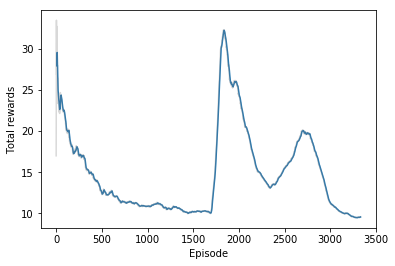

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

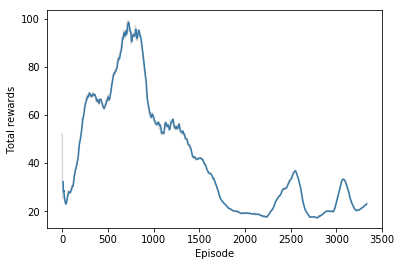

In [83]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

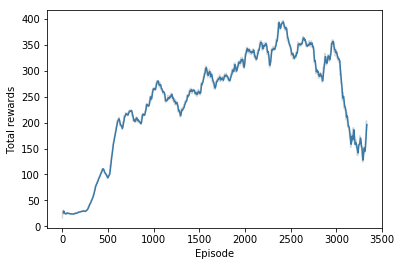

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

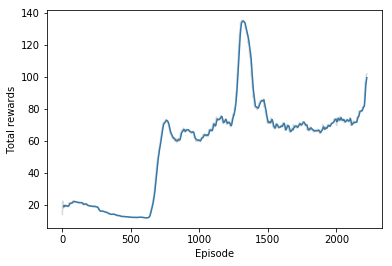

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

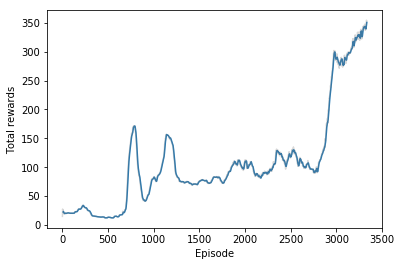

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

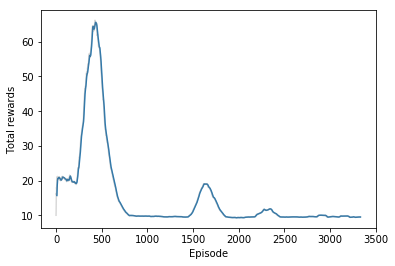

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

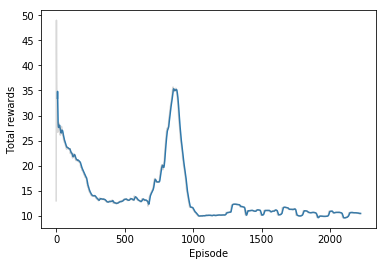

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

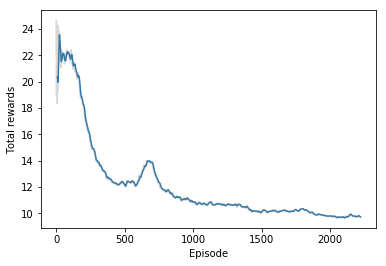

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

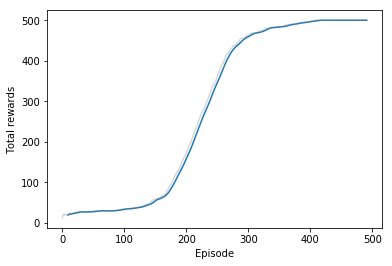

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

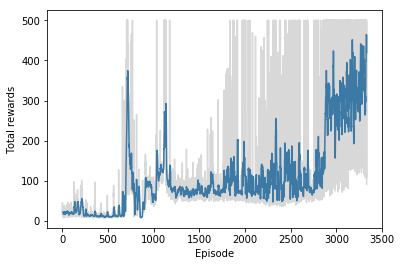

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

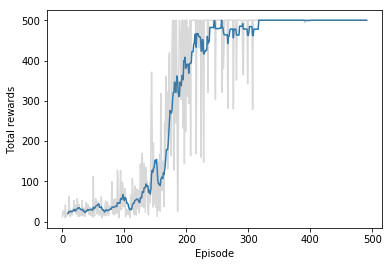

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.